In [1]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/mistral-7b-v0.3-bnb-4bit",      # New Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/llama-3-8b-bnb-4bit",           # Llama-3 15 trillion tokens model 2x faster!
    "unsloth/llama-3-8b-Instruct-bnb-4bit",
    "unsloth/llama-3-70b-bnb-4bit",
    "unsloth/Phi-3-mini-4k-instruct",        # Phi-3 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/mistral-7b-bnb-4bit",
    "unsloth/gemma-7b-bnb-4bit",             # Gemma 2.2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.8: Fast Llama patching. Transformers: 4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/198 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.12.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [vicgalle](https://huggingface.co/datasets/vicgalle/alpaca-gpt4), which is a version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html) generated from GPT4. You can replace this code section with your own data prep.

In [4]:
from datasets import load_dataset

# Specify the path to your JSON file
json_file_path = "/content/educational_content.json"

# Load the dataset from the JSON file
dataset = load_dataset("json", data_files=json_file_path, split="train")

# Print the column names
print(dataset.column_names)


Generating train split: 0 examples [00:00, ? examples/s]

['input', 'instruction', 'output']


In [5]:
print(dataset.column_names)

['input', 'instruction', 'output']


In [6]:
from unsloth import to_sharegpt
dataset = to_sharegpt(
    dataset,
    merged_prompt = "{instruction}[[\nYour input is:\n{input}]]",
    output_column_name = "output",
    conversation_extension = 3, # Select more to handle longer conversations
)

Merging columns:   0%|          | 0/325 [00:00<?, ? examples/s]

Converting to ShareGPT:   0%|          | 0/325 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/325 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/325 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/325 [00:00<?, ? examples/s]

Extending conversations:   0%|          | 0/325 [00:00<?, ? examples/s]

In [7]:
dataset[0]

{'conversations': [{'from': 'human',
   'value': 'Create a detailed content explaining this topic.\nYour input is:\nMachine Learning'},
  {'from': 'gpt',
   'value': '**Slide 1: Machine Learning**\n\n*Machine Learning is a subset of Artificial Intelligence that enables systems to learn and improve from data without explicit programming. It focuses on developing algorithms that can identify patterns, make decisions, and predict outcomes.*\n\n- *Key Concepts:*\n\t+ *Data-driven learning: ML models improve with more data and experience.*\n\t+ *Types of learning: supervised, unsupervised, semi-supervised, and reinforcement learning.*\n\n**Slide 2: Machine Learning in Action**\n\n*Machine Learning has numerous real-world applications, from personalized recommendations to fraud detection and self-driving cars.*\n\n- *Practical Examples:*\n\t+ *Natural Language Processing: sentiment analysis, language translation, and chatbots.*\n\t+ *Computer Vision: image recognition, object detection, and 

Finally use `standardize_sharegpt` to fix up the dataset!

In [8]:
from unsloth import standardize_sharegpt
dataset = standardize_sharegpt(dataset)

Standardizing format:   0%|          | 0/325 [00:00<?, ? examples/s]

### Customizable Chat Templates

You also need to specify a chat template. Previously, you could use the Alpaca format as shown below.

In [9]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

Now, you have to use `{INPUT}` for the instruction and `{OUTPUT}` for the response.

We also allow you to use an optional `{SYSTEM}` field. This is useful for Ollama when you want to use a custom system prompt (also like in ChatGPT).

You can also not put a `{SYSTEM}` field, and just put plain text.

```python
chat_template = """{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""
```

Use below if you want to use the Llama-3 prompt format. You must use the `instruct` and not the `base` model if you use this!
```python
chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM}<|eot_id|><|start_header_id|>user<|end_header_id|>

{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{OUTPUT}<|eot_id|>"""
```

For the ChatML format:
```python
chat_template = """<|im_start|>system
{SYSTEM}<|im_end|>
<|im_start|>user
{INPUT}<|im_end|>
<|im_start|>assistant
{OUTPUT}<|im_end|>"""
```

The issue is the Alpaca format has 3 fields, whilst OpenAI style chatbots must only use 2 fields (instruction and response). That's why we used the `to_sharegpt` function to merge these columns into 1.

In [10]:
chat_template = """{SYSTEM}
USER: {INPUT}
ASSISTANT: {OUTPUT}"""

from unsloth import apply_chat_template
dataset = apply_chat_template(
    dataset,
    tokenizer = tokenizer,
    chat_template = chat_template,
    # default_system_message = "You are a helpful assistant", << [OPTIONAL]
)

Unsloth: We automatically added an EOS token to stop endless generations.


Map:   0%|          | 0/325 [00:00<?, ? examples/s]

In [11]:
dataset[0]

{'conversations': [{'content': 'Create a detailed content explaining this topic.\nYour input is:\nMachine Learning',
   'role': 'user'},
  {'content': '**Slide 1: Machine Learning**\n\n*Machine Learning is a subset of Artificial Intelligence that enables systems to learn and improve from data without explicit programming. It focuses on developing algorithms that can identify patterns, make decisions, and predict outcomes.*\n\n- *Key Concepts:*\n\t+ *Data-driven learning: ML models improve with more data and experience.*\n\t+ *Types of learning: supervised, unsupervised, semi-supervised, and reinforcement learning.*\n\n**Slide 2: Machine Learning in Action**\n\n*Machine Learning has numerous real-world applications, from personalized recommendations to fraud detection and self-driving cars.*\n\n- *Practical Examples:*\n\t+ *Natural Language Processing: sentiment analysis, language translation, and chatbots.*\n\t+ *Computer Vision: image recognition, object detection, and facial recognit

In [12]:
print(dataset.column_names)

['conversations', 'text']


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 15,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 15,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Map (num_proc=2):   0%|          | 0/325 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [14]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.613 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 325 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 15
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.414900
2,1.360500
3,1.367800
4,1.433600
5,1.314300
6,1.288900
7,1.233300
8,1.216300
9,1.177000
10,1.152900


In [ ]:
trainer_stats


In [ ]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

<a name="Inference"></a>
### Inference
Let's run the model! Unsloth makes inference natively 2x faster as well! You should use prompts which are similar to the ones you had finetuned on, otherwise you might get bad results!

In [45]:

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [                    # Change below!
    {"role": "user", "content": "You are tasked with generating structured JSON content for a PowerPoint presentation on the topic of Machine Learning. Follow these rules carefully: Each slide should contain:- heading: A slide heading that concisely summarizes the main topic of the slide.- bullet_points: 3 to 5 points explaining the content, each point under 30 words, using concise and informative language.- key_message: A one-sentence takeaway that is short and informative, capturing the main idea of the slide.- img_keywords: Maximum of 3 keywords separated by commas, which describe images representing the content. This applies only to slides with regular content (not for Step-by-Step Process or Table slides).- For slides comparing features or attributes, include table_data as a list of lists in the format [[Feature, Attribute], [Feature A, Value A1], ...] to structure comparisons.- For slides detailing a process, add a Step-by-Step Process under bullet_points with points prefixed by '>>'. Each point should be exactly three words, representing each step concisely without including step numbers.Include a concluding slide titled Conclusion summarizing the main ideas of the presentation.Output the content in structured JSON format with these keys for each slide:- heading, bullet_points, key_message, img_keywords- Include table_data only when comparing features, and Step-by-Step Process only when outlining a process."},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,

    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 1112225, pad_token_id = tokenizer.eos_token_id)

1. Machine Learning
    heading: Machine Learning
    bullet_points: 
      - Supervised Learning: Algorithm learns from labeled data to make predictions.
      - Unsupervised Learning: Algorithm clusters unlabeled data to find patterns.
      - Reinforcement Learning: Algorithm learns by trial and error to maximize reward.
    key_message: Machine Learning is a field of AI that uses algorithms to learn from data and make predictions.
    img_keywords: machine, learning, algorithm, data
2. Machine Learning
    heading: Machine Learning
    bullet_points: 
      - Machine Learning: A subset of AI that teaches computers to learn without explicit programming.
      - Supervised Learning: Algorithm learns from labeled data to make predictions.
      - Unsupervised Learning: Algorithm clusters unlabeled data to find patterns.
    key_message: Machine Learning is a key enabler of AI, enabling computers to learn from data and make decisions.
    img_keywords: machine, learning, ai, algorithm


KeyboardInterrupt: 

In [22]:
from transformers import TextStreamer

# Define the prompt template
prompt_template = """
You are tasked with generating structured JSON content for a PowerPoint presentation on the topic of "{title}". Follow these rules carefully:

Each slide should contain:
   - "heading": A slide heading that concisely summarizes the main topic of the slide.
   - "bullet_points": 3 to 5 points explaining the content, each point under 30 words, using concise and informative language.
   - "key_message": A one-sentence takeaway that is short and informative, capturing the main idea of the slide.
   - "img_keywords": Maximum of 3 keywords separated by commas, which describe images representing the content. This applies only to slides with regular content (not for Step-by-Step Process or Table slides).
   - For slides comparing features or attributes, include "table_data" as a list of lists in the format [["Feature", "Attribute"], ["Feature A", "Value A1"], ...] to structure comparisons.
   - For slides detailing a process, add a "Step-by-Step Process" under "bullet_points" with points prefixed by '>>'. Each point should be exactly three words, representing each step concisely without including step numbers.

Include a concluding slide titled "Conclusion" summarizing the main ideas of the presentation.

Output the content in structured JSON format with these keys for each slide:
  - "heading", "bullet_points", "key_message", "img_keywords"
  - Include "table_data" only when comparing features, and "Step-by-Step Process" only when outlining a process.

Example JSON format:
{{
    "title": "{title}",
    "slides": [
        {{
            "heading": "Introduction to {title}",
            "bullet_points": ["...", "..."],
            "key_message": "...",
            "img_keywords": "...","..."
        }},
        {{
            "heading": "{title} in Everyday Life",
            "bullet_points": ["...", "..."],
            "key_message": "...",
            "img_keywords": "...","..."
        }},
        {{
            "heading": "Comparison of {title} Features",
            "bullet_points": [],
            "table_data": [["Feature", "Attribute"], ["Feature A", "Value A1"]],
            "key_message": "...",
            "img_keywords": None
        }},
        {{
            "heading": "Step-by-Step Process for {title}",
            "bullet_points": [">> Define Problem", ">> Gather Data", ">> Model Training"],
            "key_message": "...",
            "img_keywords": None
        }},
        {{
            "heading": "Conclusion: Embracing {title}'s Potential",
            "bullet_points": ["...", "..."],
            "key_message": "...",
            "img_keywords": "...","..."
        }}
    ]
}}
"""

# Replace the placeholder with the actual title
title = "Machine Learning"
prompt = prompt_template.format(title=title)

# Prepare messages for the model
messages = [
    {"role": "user", "content": prompt}
]

# Tokenize and prepare input IDs
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
).to("cuda")

# Define the text streamer
text_streamer = TextStreamer(tokenizer, skip_prompt=True)

# Generate the response using the model
_ = model.generate(
    input_ids,
    streamer=text_streamer,
    pad_token_id=tokenizer.eos_token_id
)


<|end_of_text|>


In [21]:
prompt

'\nYou are tasked with generating structured JSON content for a PowerPoint presentation on the topic of "Machine Learning". Follow these rules carefully:\n\nEach slide should contain:\n   - "heading": A slide heading that concisely summarizes the main topic of the slide.\n   - "bullet_points": 3 to 5 points explaining the content, each point under 30 words, using concise and informative language.\n   - "key_message": A one-sentence takeaway that is short and informative, capturing the main idea of the slide.\n   - "img_keywords": Maximum of 3 keywords separated by commas, which describe images representing the content. This applies only to slides with regular content (not for Step-by-Step Process or Table slides).\n   - For slides comparing features or attributes, include "table_data" as a list of lists in the format [["Feature", "Attribute"], ["Feature A", "Value A1"], ...] to structure comparisons.\n   - For slides detailing a process, add a "Step-by-Step Process" under "bullet_point

In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.6 MB/s eta 0:00:00


## HellaSwagTest Data  -- Reasoning abilities  

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from bert_score import score
import torch
from difflib import SequenceMatcher

# Load HellaSwag dataset
hella_dataset = load_dataset("hellaswag", split="validation")


# Function to compute edit distance
def compute_edit_distance(a, b):
    return 1 - SequenceMatcher(None, a, b).ratio()

# Evaluate first 30 rows
results = []
num_examples = 30

for i in range(num_examples):
    example = hella_dataset[i]
    context = example["ctx"]  # Context sentence
    endings = example["endings"]  # Multiple-choice completions

    # Ensure correct_label is an integer
    correct_label = int(example["label"])  # Convert label to integer if necessary
    reference_text = endings[correct_label]

    # Tokenize context + ending
    input_ids = [
        tokenizer(context + " " + ending, return_tensors="pt", truncation=True, max_length=512).input_ids.to("cuda")
        for ending in endings
    ]

    # Generate log-likelihoods for each choice
    log_probs = []
    for ids in input_ids:
        with torch.no_grad():
            outputs = model(ids, labels=ids)
        log_probs.append(-outputs.loss.item() * ids.size(1))  # Negative log-likelihood

    # Select the model's best prediction
    predicted_index = torch.argmax(torch.tensor(log_probs))
    predicted_text = endings[predicted_index]

    # Compute BERTScore
    P, R, F1 = score([predicted_text], [reference_text], lang="en", verbose=False)

    # Compute Edit Distance
    edit_distance = compute_edit_distance(predicted_text, reference_text)

    # Store results
    results.append({
        "context": context,
        "reference": reference_text,
        "predicted": predicted_text,
        "bert_score_f1": F1.mean().item(),
        "edit_distance": edit_distance,
        "correct": int(predicted_index == correct_label)
    })



README.md:   0%|          | 0.00/6.84k [00:00<?, ?B/s]

hellaswag.py:   0%|          | 0.00/4.36k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.53k [00:00<?, ?B/s]

The repository for hellaswag contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hellaswag.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

In [ ]:
# Summarize results
total_correct = sum([res["correct"] for res in results])
average_bert_score = sum([res["bert_score_f1"] for res in results]) / num_examples
average_edit_distance = sum([res["edit_distance"] for res in results]) / num_examples

print(f"Accuracy: {total_correct / num_examples:.2f}")
print(f"Average BERTScore (F1): {average_bert_score:.4f}")
print(f"Average Edit Distance: {average_edit_distance:.4f}")

# Optional: Print detailed results
for i, res in enumerate(results):
    print(f"\nExample {i + 1}")
    print(f"Context: {res['context']}")
    print(f"Reference: {res['reference']}")
    print(f"Predicted: {res['predicted']}")
    print(f"BERTScore (F1): {res['bert_score_f1']:.4f}")
    print(f"Edit Distance: {res['edit_distance']:.4f}")
    print(f"Correct: {'Yes' if res['correct'] else 'No'}")

Accuracy: 0.47
Average BERTScore (F1): 0.9278
Average Edit Distance: 0.3527

Example 1
Context: A man is sitting on a roof. he
Reference: starts pulling up roofing on a roof.
Predicted: is holding a rubik's cube.
BERTScore (F1): 0.8791
Edit Distance: 0.6452
Correct: No

Example 2
Context: A lady walks to a barbell. She bends down and grabs the pole. the lady
Reference: stands and lifts the weight over her head.
Predicted: pulls the barbell forward.
BERTScore (F1): 0.8777
Edit Distance: 0.7059
Correct: No

Example 3
Context: Two women in a child are shown in a canoe while a man pulls the canoe while standing in the water, with other individuals visible in the background. the child and a different man
Reference: sit in a canoe while the man paddles.
Predicted: sit in a canoe while the man paddles.
BERTScore (F1): 1.0000
Edit Distance: 0.0000
Correct: Yes

Example 4
Context: A boy is running down a track. the boy
Reference: lifts his body above the height of a pole.
Predicted: runs into a

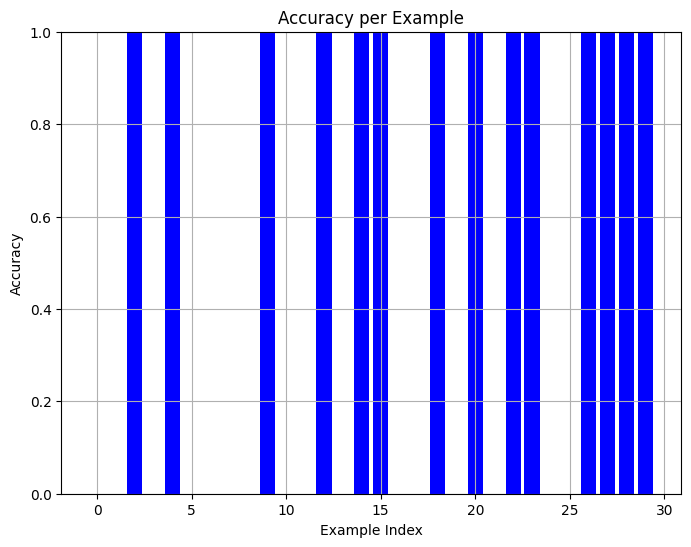

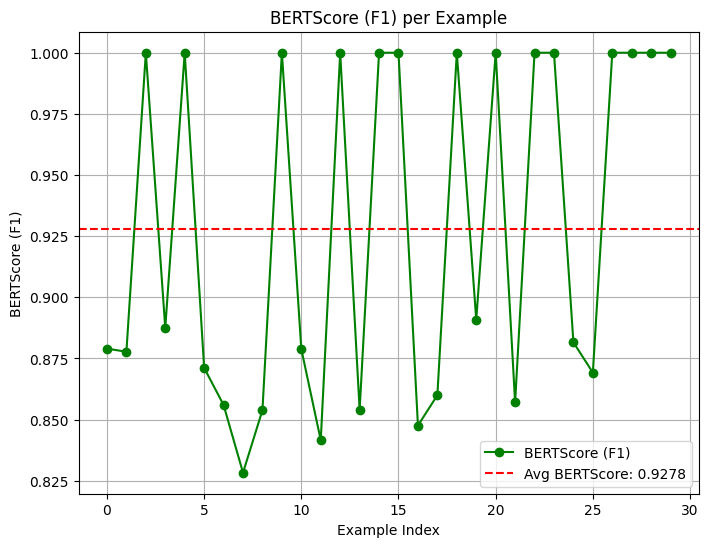

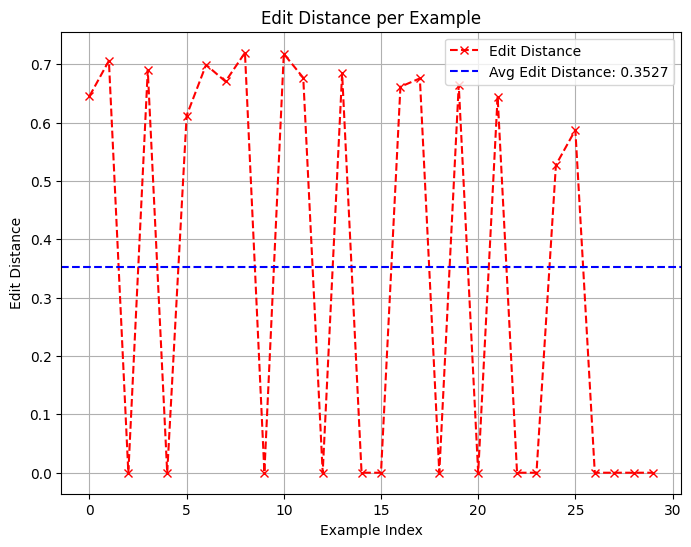

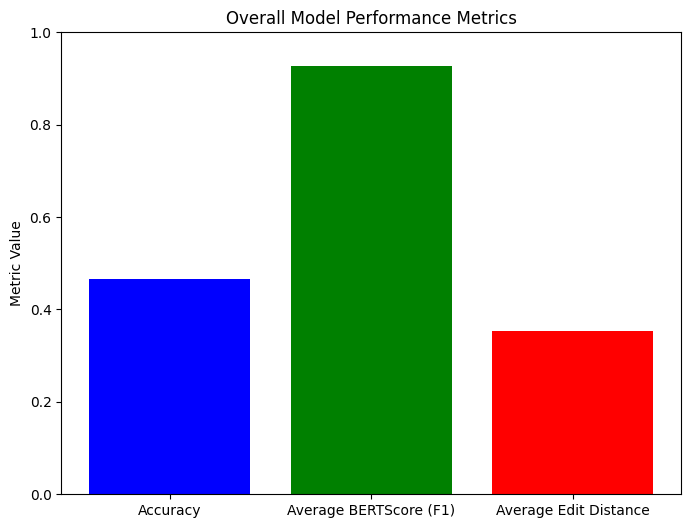

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' contains the evaluation data as a list of dictionaries from your previous code

# Extract data for plotting
accuracies = [res['correct'] for res in results]
bert_scores = [res['bert_score_f1'] for res in results]
edit_distances = [res['edit_distance'] for res in results]

# Calculate overall metrics for plotting (Accuracy, Average BERTScore, Average Edit Distance)
accuracy = total_correct / num_examples
average_bert_score = average_bert_score
average_edit_distance = average_edit_distance

# -----------------------
# Plot Accuracy
# -----------------------
plt.figure(figsize=(8, 6))
plt.bar(range(num_examples), accuracies, color='blue', label='Accuracy')
plt.ylim(0, 1)
plt.xlabel('Example Index')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Example')
plt.grid(True)
plt.show()

# -----------------------
# Plot Average BERTScore (F1)
# -----------------------
plt.figure(figsize=(8, 6))
plt.plot(range(num_examples), bert_scores, label='BERTScore (F1)', marker='o', linestyle='-', color='green')
plt.axhline(y=average_bert_score, color='r', linestyle='--', label=f'Avg BERTScore: {average_bert_score:.4f}')
plt.xlabel('Example Index')
plt.ylabel('BERTScore (F1)')
plt.title(f'BERTScore (F1) per Example')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# Plot Edit Distance
# -----------------------
plt.figure(figsize=(8, 6))
plt.plot(range(num_examples), edit_distances, label='Edit Distance', marker='x', linestyle='--', color='red')
plt.axhline(y=average_edit_distance, color='b', linestyle='--', label=f'Avg Edit Distance: {average_edit_distance:.4f}')
plt.xlabel('Example Index')
plt.ylabel('Edit Distance')
plt.title(f'Edit Distance per Example')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------
# Plot Overall Metrics
# -----------------------
plt.figure(figsize=(8, 6))
metrics = ['Accuracy', 'Average BERTScore (F1)', 'Average Edit Distance']
values = [accuracy, average_bert_score, average_edit_distance]
plt.bar(metrics, values, color=['blue', 'green', 'red'])
plt.ylim(0, 1)
plt.ylabel('Metric Value')
plt.title('Overall Model Performance Metrics')
plt.show()


In [ ]:
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 49.8 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=9d255ef699deae6602e69930552ffd8e8c71586fddc730f1ff5f9f3e79538f6b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00


In [ ]:
dataset

Dataset({
    features: ['conversations', 'text'],
    num_rows: 213
})

## Actual DataSet Testing

# BERTScore (F1):
Measures **semantic similarity** between the model's output and the reference text

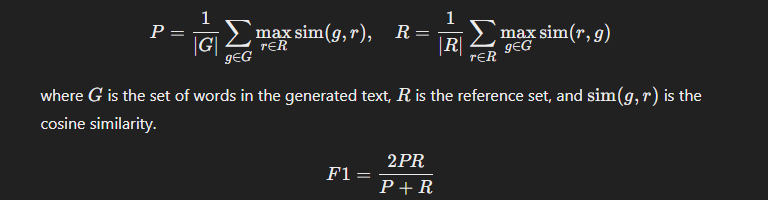



# ROUGE (ROUGE-1, ROUGE-2, ROUGE-L)
Measures **n-gram overlap** between the generated text and the reference. how much the **generated text preserves specific content** from the reference.

---

***Details:***

**ROUGE-1:** Measures unigram overlap (word-level overlap).

**ROUGE-2:** Measures bigram overlap (two consecutive words).

**ROUGE-L:** Measures the longest common subsequence (LCS), capturing sentence structure.

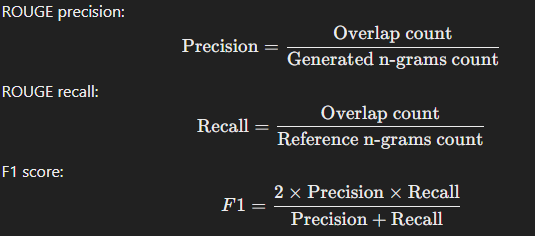

# METEOR

Goes beyond exact word matches by considering **semantic matches, stemming, and synonymy**. Ensures that minor differences in **word forms (e.g., plurals, synonyms)** don't negatively affect the score.

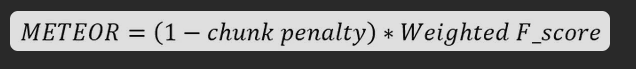

# Perplexity

Perplexity is a **measurement that reflects how well a model can predict the next word** based on the preceding context.

Why it's important: A **low perplexity indicates the model is confident** in its predictions, suggesting fluency and coherence.

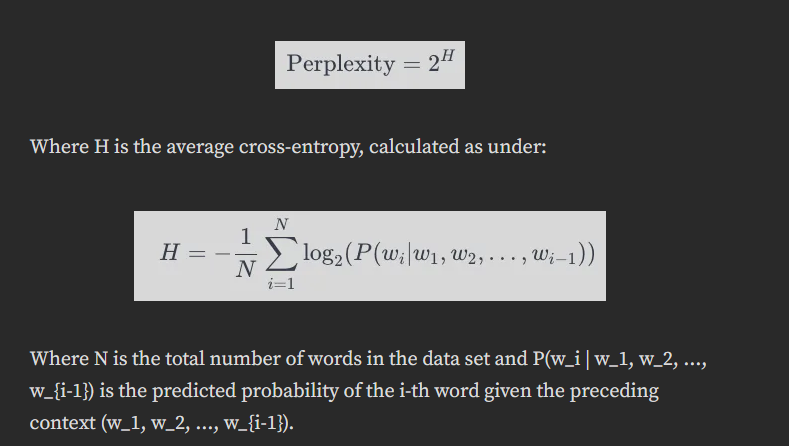


# Toxicity
Measures whether the generated text includes **harmful, offensive, or toxic content**

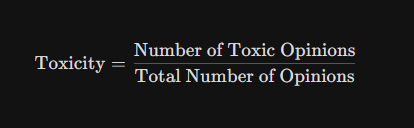

# Flesch Reading Ease
Ensures that generated text is accessible and not overly complex.

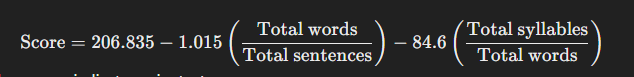

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from bert_score import score
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import textstat
import evaluate
from datasets import load_dataset

# Setup CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load toxicity evaluation metric
toxicity_metric = evaluate.load("toxicity")

# Function to compute perplexity
def compute_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).input_ids.to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    return torch.exp(outputs.loss).item()

# Function to extract user and assistant texts
def extract_conversation_texts(conversations):
    user_texts = [msg['content'] for msg in conversations if msg['role'] == 'user']
    assistant_texts = [msg['content'] for msg in conversations if msg['role'] == 'assistant']
    return user_texts, assistant_texts

# Function to compute various metrics
def compute_metrics(predicted_text, reference_text):
    # Tokenize reference and prediction for metrics requiring tokenized inputs
    reference_tokens = reference_text.split()
    predicted_tokens = predicted_text.split()

    # Compute BERTScore
    P, R, F1 = score([predicted_text], [reference_text], lang="en", verbose=False)

    # Compute ROUGE
    rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = rouge.score(reference_text, predicted_text)

    # Compute METEOR
    meteor = meteor_score([reference_tokens], predicted_tokens)

    # Compute Perplexity
    try:
        perplexity = compute_perplexity(model, tokenizer, predicted_text)
    except Exception as e:
        print(f"Perplexity computation error: {e}")
        perplexity = float('nan')

    # Compute Flesch Reading Ease
    try:
        reading_ease = textstat.flesch_reading_ease(predicted_text)
    except Exception as e:
        print(f"Reading ease computation error: {e}")
        reading_ease = float('nan')

    # Compute Toxicity
    try:
        toxicity = toxicity_metric.compute(predictions=[predicted_text])["toxicity"][0]
    except Exception as e:
        print(f"Toxicity computation error: {e}")
        toxicity = float('nan')

    return {
        "bert_score_f1": F1.mean().item(),
        "rouge1": rouge_scores["rouge1"].fmeasure,
        "rouge2": rouge_scores["rouge2"].fmeasure,
        "rougeL": rouge_scores["rougeL"].fmeasure,
        "meteor": meteor,
        "perplexity": perplexity,
        "reading_ease": reading_ease,
        "toxicity": toxicity,
    }

# Evaluation results
results = []
num_examples = min(50, len(dataset))

# Generate text and evaluate metrics
for i in range(num_examples):
    # Extract conversation
    conversations = dataset[i]['conversations']

    # Extract user and assistant texts
    user_texts, assistant_texts = extract_conversation_texts(conversations)

    # Use the last user text and assistant text if multiple exist
    user_input = user_texts[-1] if user_texts else ""
    reference_text = assistant_texts[-1] if assistant_texts else ""

    # Skip if no valid texts
    if not user_input or not reference_text:
        continue

    # Tokenize user input
    input_ids = tokenizer(
        user_input,
        return_tensors="pt",
        truncation=True,
        max_length=512,
    ).input_ids.to(device)

    # Generate text
    generated_tokens = model.generate(
        input_ids, max_new_tokens=128, pad_token_id=tokenizer.eos_token_id
    )

    # Decode generated tokens
    predicted_text = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)

    # Compute metrics
    metrics = compute_metrics(predicted_text, reference_text)

    # Store results
    results.append({
        "user_input": user_input,
        "reference": reference_text,
        "predicted": predicted_text,
        **metrics
    })



Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predi

Average Metrics: {'bert_score_f1': 0.8195922183990478, 'rouge1': 0.21286126919192427, 'rouge2': 0.07812752393618655, 'rougeL': 0.1540321974045963, 'meteor': 0.08818826740097534, 'perplexity': 5.946238219738007, 'reading_ease': 39.2278, 'toxicity': 0.0019333669979823753}


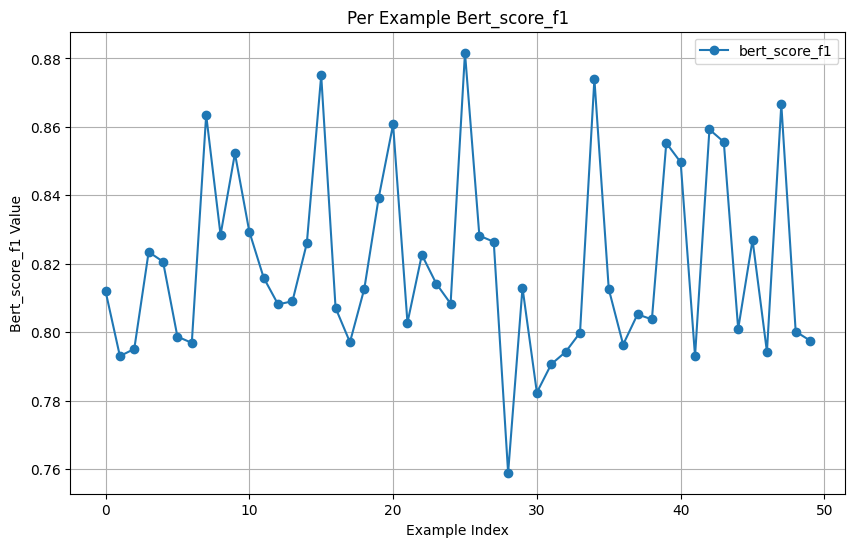

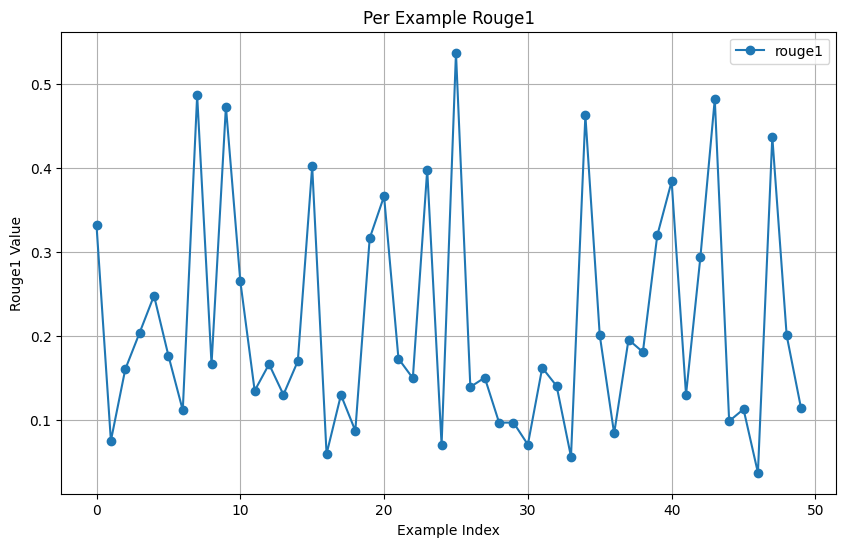

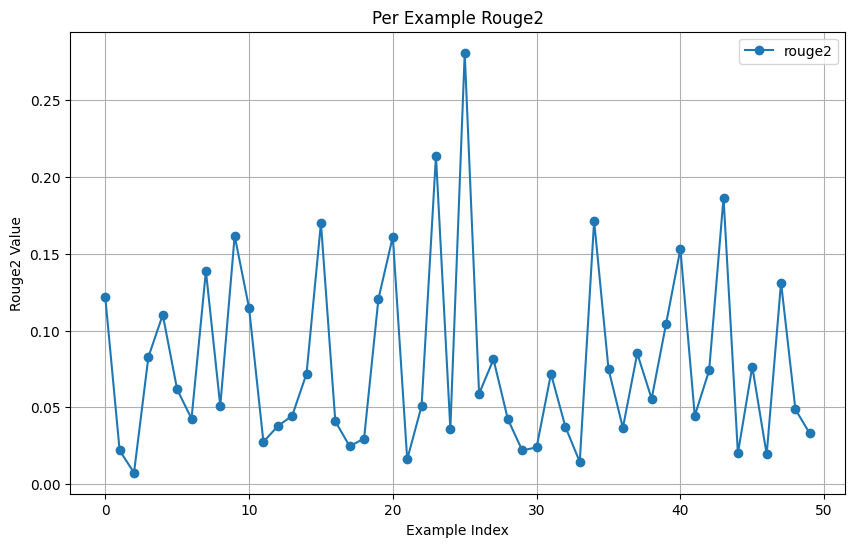

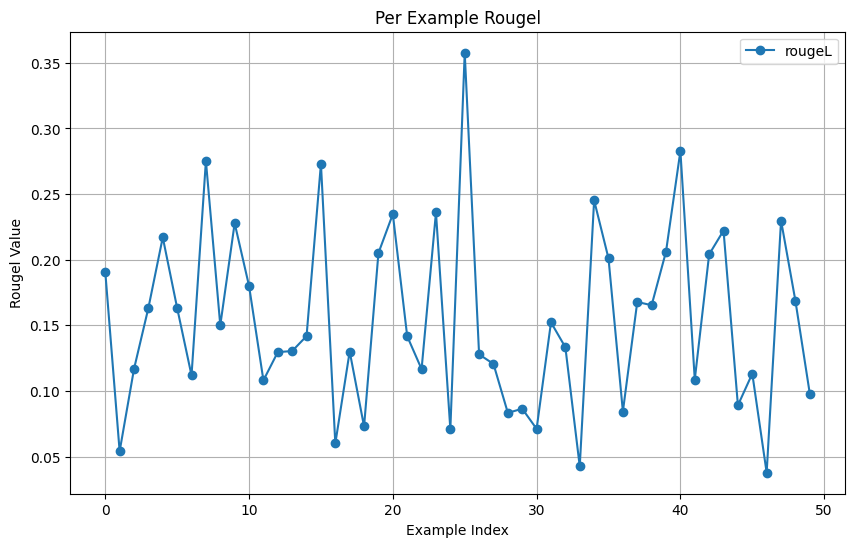

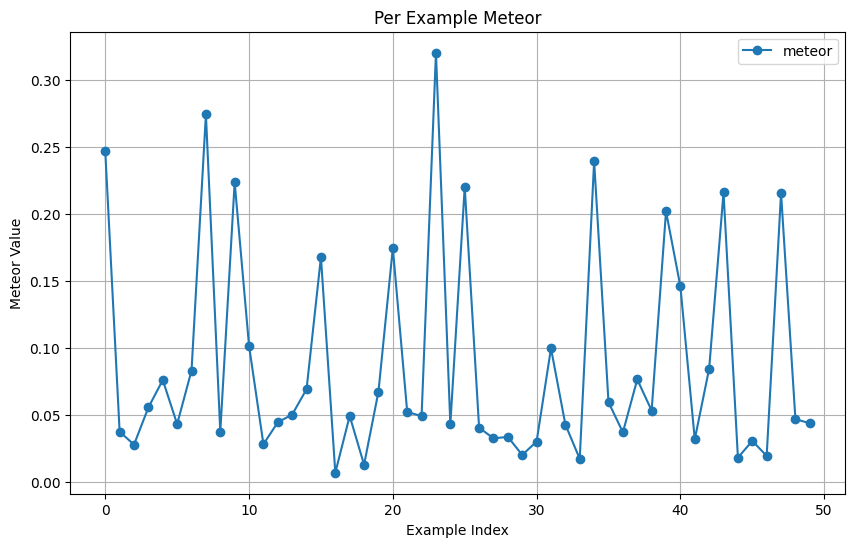

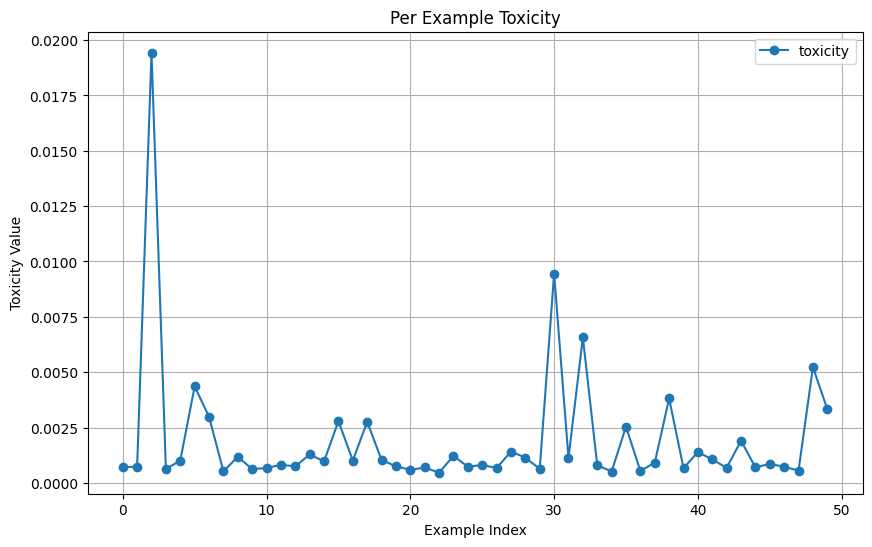

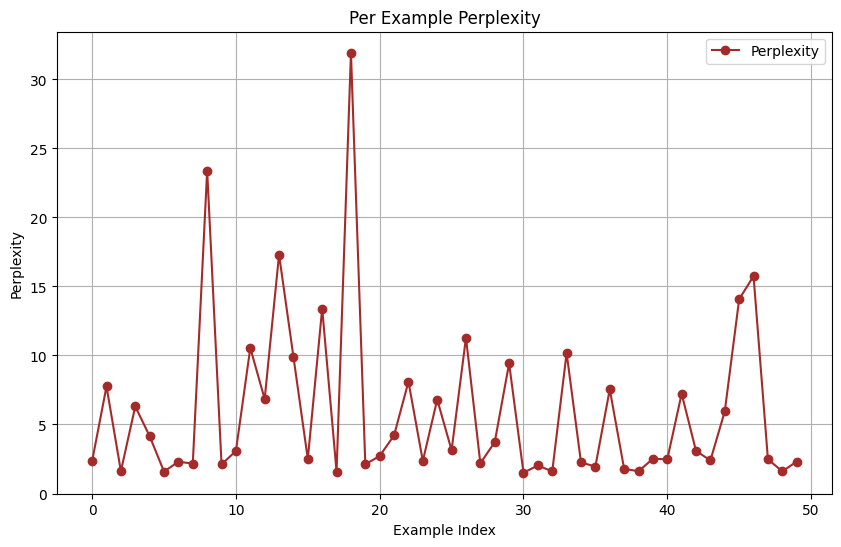

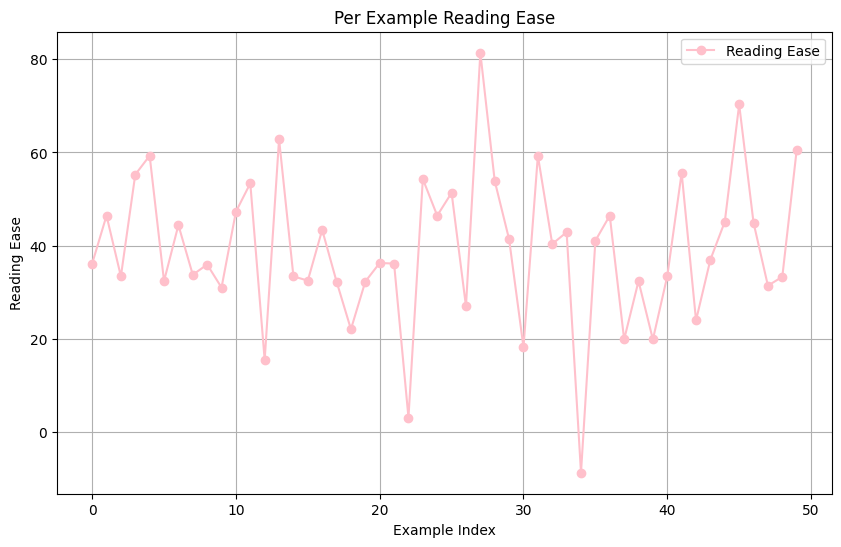

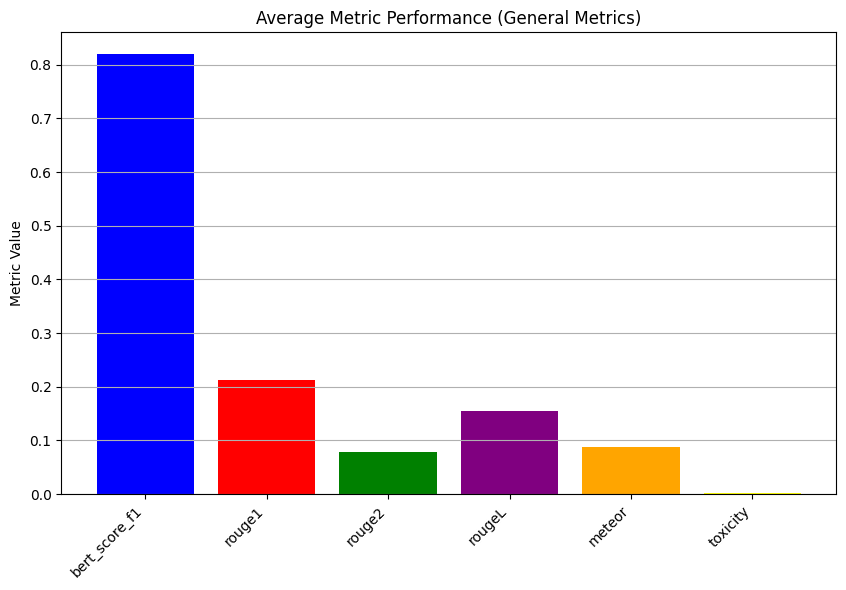

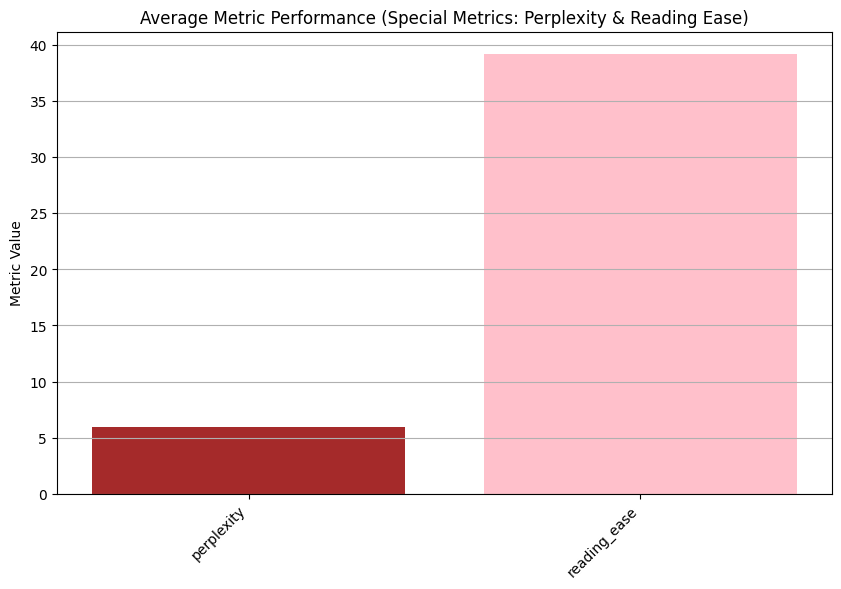

In [ ]:
# Summarize results
averages = {metric: np.mean([res[metric] for res in results if res[metric] is not None])
            for metric in results[0] if metric not in ['user_input', 'reference', 'predicted']}
print(f"Average Metrics: {averages}")

# Metrics to plot (group general metrics separately)
general_metrics = ["bert_score_f1", "rouge1", "rouge2", "rougeL", "meteor", "toxicity"]
special_metrics = ["perplexity", "reading_ease"]

# Plotting general metrics
for metric in general_metrics:
    plt.figure(figsize=(10, 6))
    metric_values = [res[metric] for res in results if res[metric] is not None]
    plt.plot(range(len(metric_values)), metric_values, marker="o", label=metric)
    plt.xlabel("Example Index")
    plt.ylabel(f"{metric.capitalize()} Value")
    plt.title(f"Per Example {metric.capitalize()}")
    plt.grid(True)
    plt.legend()
    plt.show()

# Plotting perplexity
plt.figure(figsize=(10, 6))
perplexity_values = [res["perplexity"] for res in results if res["perplexity"] is not None]
plt.plot(range(len(perplexity_values)), perplexity_values, marker="o", color="brown", label="Perplexity")
plt.xlabel("Example Index")
plt.ylabel("Perplexity")
plt.title("Per Example Perplexity")
plt.grid(True)
plt.legend()
plt.show()

# Plotting reading ease
plt.figure(figsize=(10, 6))
reading_ease_values = [res["reading_ease"] for res in results if res["reading_ease"] is not None]
plt.plot(range(len(reading_ease_values)), reading_ease_values, marker="o", color="pink", label="Reading Ease")
plt.xlabel("Example Index")
plt.ylabel("Reading Ease")
plt.title("Per Example Reading Ease")
plt.grid(True)
plt.legend()
plt.show()

# Plot average values for general metrics
general_average_values = [averages.get(metric, 0) for metric in general_metrics]
plt.figure(figsize=(10, 6))
colors_general = ["blue", "red", "green", "purple", "orange", "yellow"]  # Colors for general metrics
plt.bar(general_metrics, general_average_values, color=colors_general)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Metric Value")
plt.title("Average Metric Performance (General Metrics)")
plt.grid(True, axis="y")
plt.show()

# Plot average values for special metrics
special_average_values = [averages.get(metric, 0) for metric in special_metrics]
plt.figure(figsize=(10, 6))
colors_special = ["brown", "pink"]  # Colors for special metrics
plt.bar(special_metrics, special_average_values, color=colors_special)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Metric Value")
plt.title("Average Metric Performance (Special Metrics: Perplexity & Reading Ease)")
plt.grid(True, axis="y")
plt.show()



In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# HellaSwag Dataset -- Full Metrics Eval

In [ ]:
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from bert_score import score
import torch
from difflib import SequenceMatcher
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import textstat
import evaluate

nltk.download("wordnet")

# Load HellaSwag dataset
dataset = load_dataset("hellaswag", split="validation")

# Load toxicity evaluation module
toxicity_metric = evaluate.load("toxicity")

# Function to compute edit distance
def compute_edit_distance(a, b):
    return 1 - SequenceMatcher(None, a, b).ratio()

# Function to compute perplexity
def compute_perplexity(model, tokenizer, text):
    input_ids = tokenizer(text, return_tensors="pt", truncation=True).input_ids.to("cuda")
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
    return torch.exp(outputs.loss).item()

# Evaluate first 30 rows
results = []
num_examples = 50

for i in range(num_examples):
    example = dataset[i]
    context = example["ctx"]  # Context sentence
    endings = example["endings"]  # Multiple-choice completions

    # Ensure correct_label is an integer
    correct_label = int(example["label"])  # Convert label to integer if necessary
    reference_text = endings[correct_label]

    # Tokenize context + ending
    input_ids = [
        tokenizer(context + " " + ending, return_tensors="pt", truncation=True, max_length=512).input_ids.to("cuda")
        for ending in endings
    ]

    # Generate log-likelihoods for each choice
    log_probs = []
    for ids in input_ids:
        with torch.no_grad():
            outputs = model(ids, labels=ids)
        log_probs.append(-outputs.loss.item() * ids.size(1))  # Negative log-likelihood

    # Select the model's best prediction
    predicted_index = torch.argmax(torch.tensor(log_probs))
    predicted_text = endings[predicted_index]

    # Compute BERTScore
    P, R, F1 = score([predicted_text], [reference_text], lang="en", verbose=False)

    # Compute Edit Distance
    edit_distance = compute_edit_distance(predicted_text, reference_text)

    # Compute ROUGE
    rouge = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)
    rouge_scores = rouge.score(predicted_text, reference_text)

    # Compute METEOR
    # meteor = meteor_score([reference_text], predicted_text)

    # Compute Perplexity
    perplexity = compute_perplexity(model, tokenizer, predicted_text)

    # Compute Flesch Reading Ease
    reading_ease = textstat.flesch_reading_ease(predicted_text)

    # Compute Toxicity
    toxicity = toxicity_metric.compute(predictions=[predicted_text])["toxicity"]

    # Store results
    results.append({
        "context": context,
        "reference": reference_text,
        "predicted": predicted_text,
        "bert_score_f1": F1.mean().item(),
        "edit_distance": edit_distance,
        "rouge1": rouge_scores["rouge1"].fmeasure,
        "rouge2": rouge_scores["rouge2"].fmeasure,
        "rougeL": rouge_scores["rougeL"].fmeasure,
        # "meteor": meteor,
        "perplexity": perplexity,
        "reading_ease": reading_ease,
        "toxicity": toxicity,
        "correct": int(predicted_index == correct_label),
    })




[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'robe

In [ ]:
# Summarize results
total_correct = sum([res["correct"] for res in results])
average_bert_score = sum([res["bert_score_f1"] for res in results]) / num_examples
average_edit_distance = sum([res["edit_distance"] for res in results]) / num_examples
average_rouge1 = sum([res["rouge1"] for res in results]) / num_examples
average_rouge2 = sum([res["rouge2"] for res in results]) / num_examples
average_rougeL = sum([res["rougeL"] for res in results]) / num_examples
# average_meteor = sum([res["meteor"] for res in results]) / num_examples
average_perplexity = sum([res["perplexity"] for res in results]) / num_examples
average_reading_ease = sum([res["reading_ease"] for res in results]) / num_examples
# average_toxicity = sum([res["toxicity"] for res in results]) / num_examples

print(f"Accuracy: {total_correct / num_examples:.2f}")
print(f"Average BERTScore (F1): {average_bert_score:.4f}")
print(f"Average Edit Distance: {average_edit_distance:.4f}")
print(f"Average ROUGE-1: {average_rouge1:.4f}")
print(f"Average ROUGE-2: {average_rouge2:.4f}")
print(f"Average ROUGE-L: {average_rougeL:.4f}")
# print(f"Average METEOR: {average_meteor:.4f}")
print(f"Average Perplexity: {average_perplexity:.4f}")
print(f"Average Flesch Reading Ease: {average_reading_ease:.2f}")
# print(f"Average Toxicity: {average_toxicity:.4f}")

Accuracy: 0.46
Average BERTScore (F1): 0.9265
Average Edit Distance: 0.3542
Average ROUGE-1: 0.5413
Average ROUGE-2: 0.4646
Average ROUGE-L: 0.5368
Average Perplexity: 305.4458
Average Flesch Reading Ease: 90.27


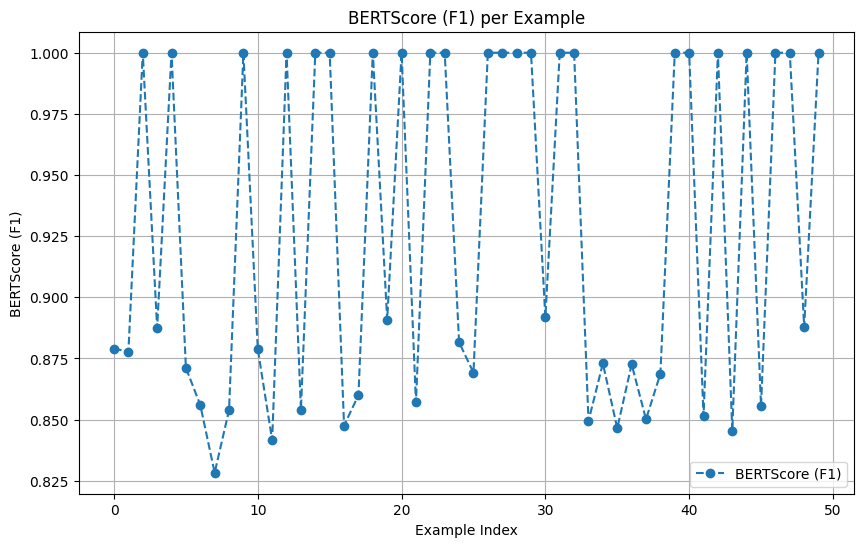

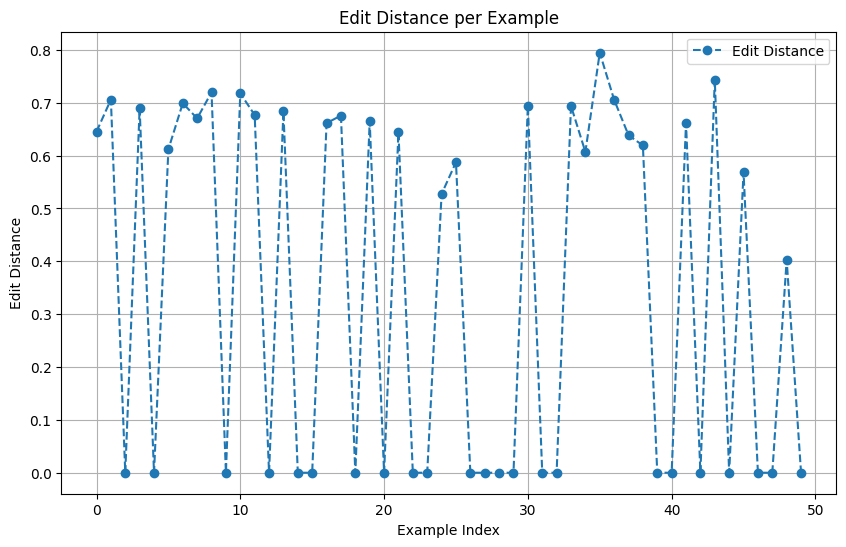

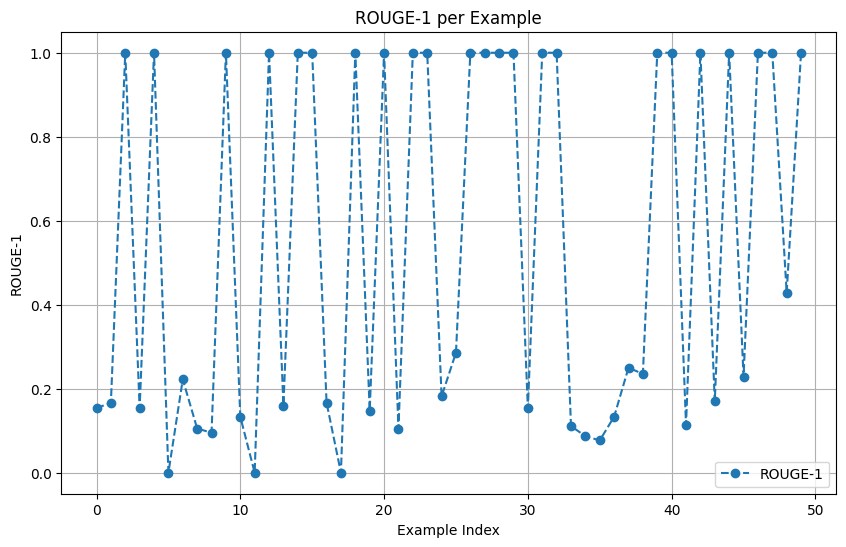

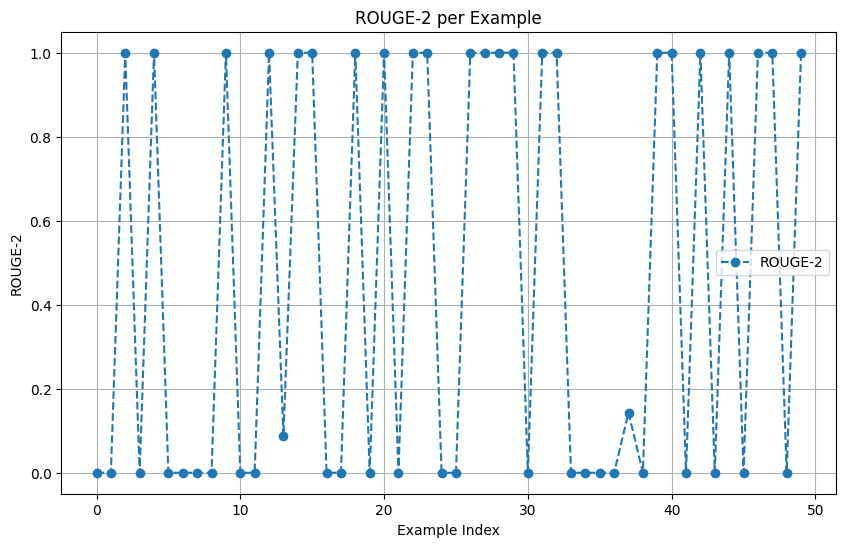

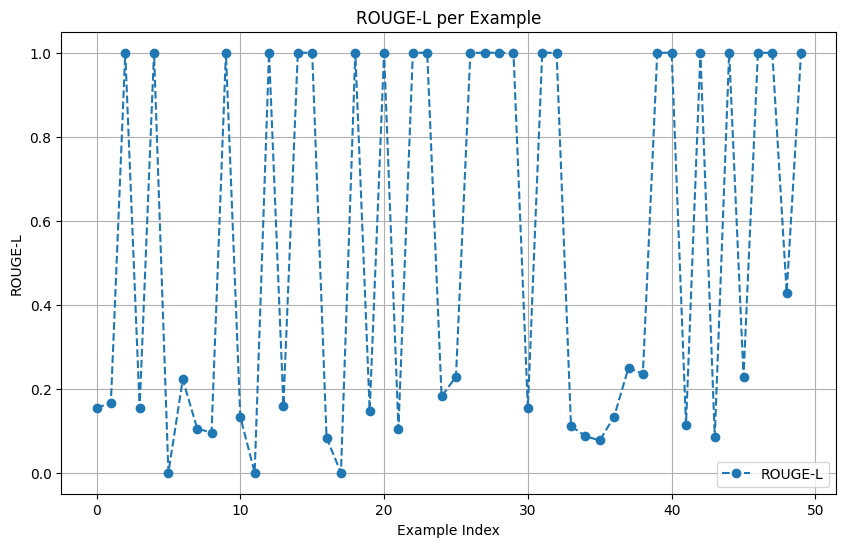

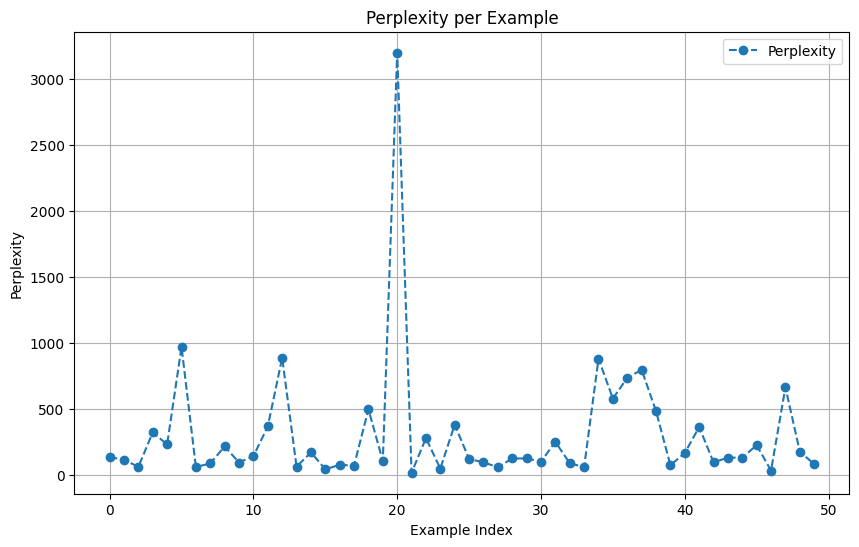

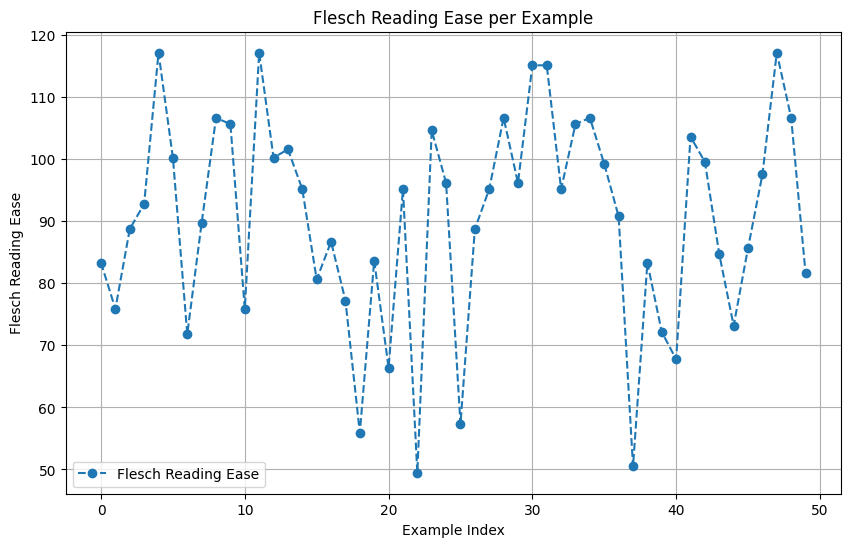

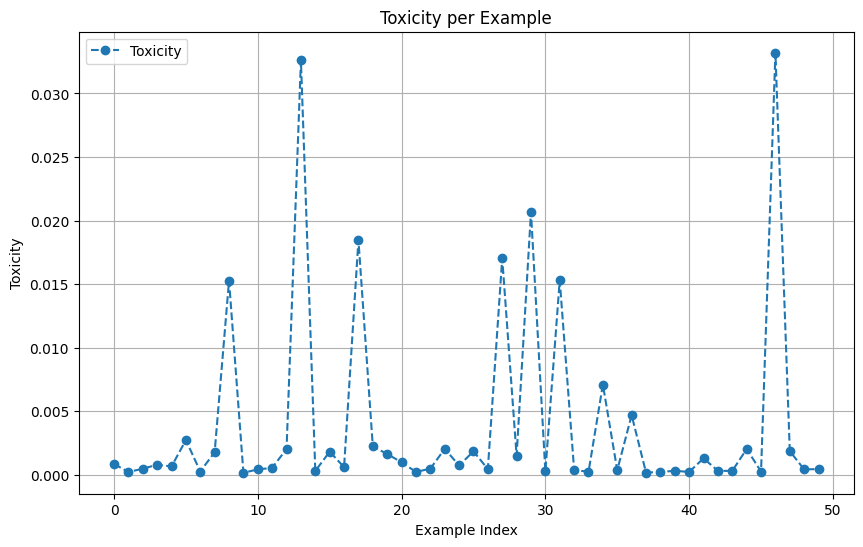

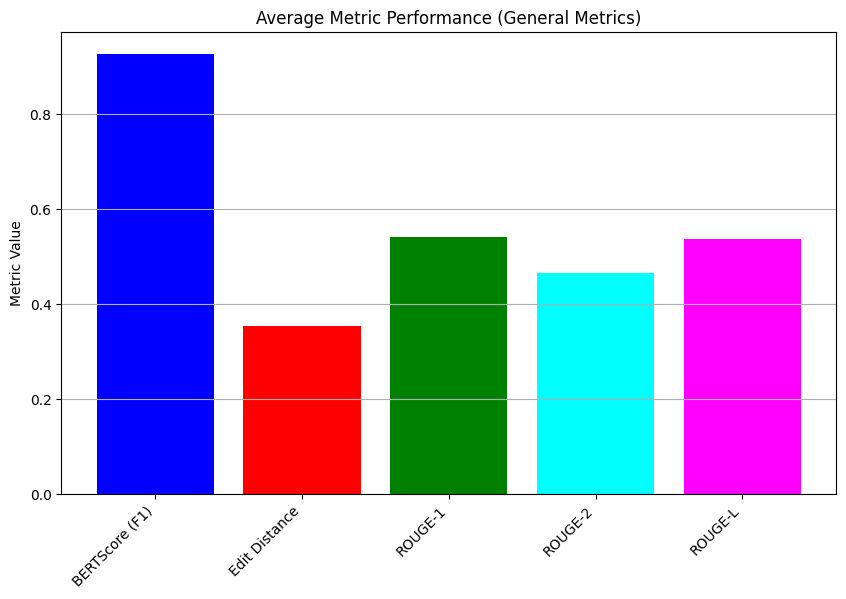

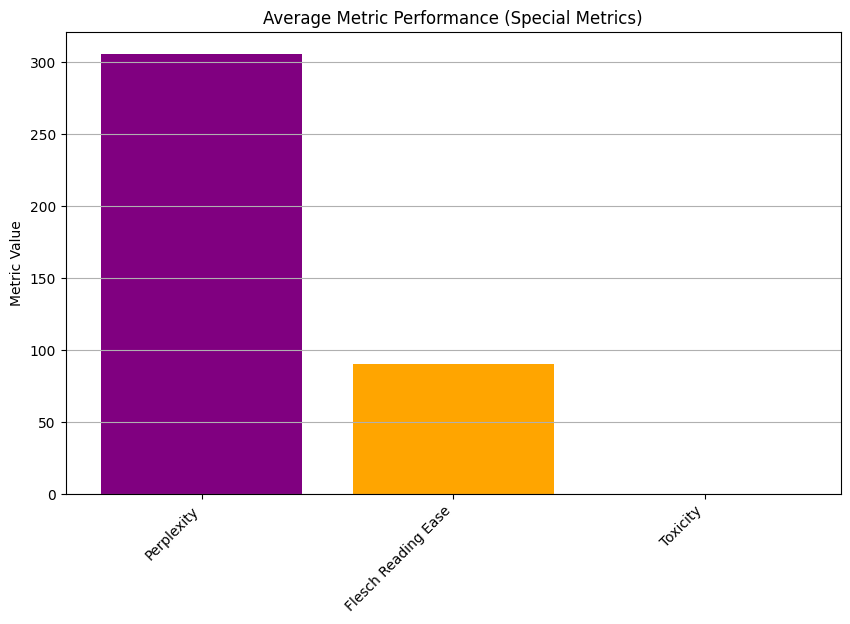

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract individual metric values from the results
bert_scores = [result["bert_score_f1"] for result in results]
edit_distances = [result["edit_distance"] for result in results]
rouge1_scores = [result["rouge1"] for result in results]
rouge2_scores = [result["rouge2"] for result in results]
rougeL_scores = [result["rougeL"] for result in results]
# meteor_scores = [result["meteor"] for result in results]  # Uncomment if METEOR is enabled
perplexities = [result["perplexity"] for result in results]
reading_eases = [result["reading_ease"] for result in results]
toxicities = [result["toxicity"] for result in results]

# Organize metrics into a dictionary for easier plotting
metrics = {
    "BERTScore (F1)": bert_scores,
    "Edit Distance": edit_distances,
    "ROUGE-1": rouge1_scores,
    "ROUGE-2": rouge2_scores,
    "ROUGE-L": rougeL_scores,
    # "METEOR": meteor_scores,  # Uncomment if METEOR is enabled
    "Perplexity": perplexities,
    "Flesch Reading Ease": reading_eases,
    "Toxicity": toxicities,
}

# Plot each metric individually
for metric, values in metrics.items():
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(values)), values, label=metric, marker="o", linestyle="--")
    plt.xlabel("Example Index")
    plt.ylabel(metric)
    plt.title(f"{metric} per Example")
    plt.grid(True)
    plt.legend()
    plt.show()

# Calculate overall averages
averages = {metric: np.mean(values) for metric, values in metrics.items()}

# Separate metrics for bar plots (categorize them based on relevance)
general_metrics = ["BERTScore (F1)", "Edit Distance", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
special_metrics = ["Perplexity", "Flesch Reading Ease", "Toxicity"]

# Plot bar graph for general metrics
general_average_values = [averages[metric] for metric in general_metrics]
plt.figure(figsize=(10, 6))
colors_general = ["blue", "red", "green", "cyan", "magenta"]
plt.bar(general_metrics, general_average_values, color=colors_general)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Metric Value")
plt.title("Average Metric Performance (General Metrics)")
plt.grid(True, axis="y")
plt.show()

# Plot bar graph for special metrics
special_average_values = [averages[metric] for metric in special_metrics]
plt.figure(figsize=(10, 6))
colors_special = ["purple", "orange", "gray"]
plt.bar(special_metrics, special_average_values, color=colors_special)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Metric Value")
plt.title("Average Metric Performance (Special Metrics)")
plt.grid(True, axis="y")
plt.show()


Since we created an actual chatbot, you can also do longer conversations by manually adding alternating conversations between the user and assistant!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
messages = [                         # Change below!
    {"role": "user",      "content": "Continue the fibonacci sequence! Your input is 1, 1, 2, 3, 5, 8"},
    {"role": "assistant", "content": "The fibonacci sequence continues as 13, 21, 34, 55 and 89."},
    {"role": "user",      "content": "What is France's tallest tower called?"},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128, pad_token_id = tokenizer.eos_token_id)

France's tallest tower is called the Eiffel Tower.<|end_of_text|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [31]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference
pass

messages = [                    # Change below!
    {"role": "user", "content": prompt},
]
input_ids = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 11112228, pad_token_id = tokenizer.eos_token_id)

<|end_of_text|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

<a name="Ollama"></a>
### Ollama Support

[Unsloth](https://github.com/unslothai/unsloth) now allows you to automatically finetune and create a [Modelfile](https://github.com/ollama/ollama/blob/main/docs/modelfile.md), and export to [Ollama](https://ollama.com/)! This makes finetuning much easier and provides a seamless workflow from `Unsloth` to `Ollama`!

Let's first install `Ollama`!

In [ ]:
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


Next, we shall save the model to GGUF / llama.cpp

We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

We also support saving to multiple GGUF options in a list fashion! This can speed things up by 10 minutes or more if you want multiple export formats!

In [ ]:
# Save to 8bit Q8_0
if True: model.save_pretrained_gguf("model", tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")

# Save to multiple GGUF options - much faster if you want multiple!
if False:
    model.push_to_hub_gguf(
        "hf/model", # Change hf to your username!
        tokenizer,
        quantization_method = ["q4_k_m", "q8_0", "q5_k_m",],
        token = "", # Get a token at https://huggingface.co/settings/tokens
    )

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.
Unsloth: You have 1 CPUs. Using `safe_serialization` is 10x slower.
We shall switch to Pytorch saving, which will take 3 minutes and not 30 minutes.
To force `safe_serialization`, set it to `None` instead.
Unsloth: Kaggle/Colab has limited disk space. We need to delete the downloaded
model which will save 4-16GB of disk space, allowing you to save on Kaggle/Colab.
Unsloth: Will remove a cached repo with size 5.7G


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 5.49 out of 12.67 RAM for saving.


100%|██████████| 32/32 [01:41<00:00,  3.18s/it]


Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... This might take 5 minutes for Llama-7b...
Unsloth: Saving model/pytorch_model-00001-of-00004.bin...
Unsloth: Saving model/pytorch_model-00002-of-00004.bin...
Unsloth: Saving model/pytorch_model-00003-of-00004.bin...
Unsloth: Saving model/pytorch_model-00004-of-00004.bin...
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp will take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits will take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q8_0'] will take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: [0] Installing llama.cpp. This will take 3 minutes...
Unsloth: [1] Converting model at model into q8_0 GGUF format.
The output location will be ./model/unsloth.Q8_0.gguf
This will take 3 minutes...
INFO:hf-to-gguf:Loading model: model
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'pytorch_model.bin.index.json'
INFO:hf-to-gguf:gguf: loading model part 'pytorch_model-00001-of-00004.bin'
INFO:hf-to-gguf:token_embd.weight,           torch.float16 --> Q8_0, shape = {4096, 128256}
INFO:hf-to-gguf:blk.0.attn_q.weight,         torch.float16 -

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.


Unsloth: Conversion completed! Output location: ./model/unsloth.Q8_0.gguf
Unsloth: Saved Ollama Modelfile to model/Modelfile


We use `subprocess` to start `Ollama` up in a non blocking fashion! In your own desktop, you can simply open up a new `terminal` and type `ollama serve`, but in Colab, we have to use this hack!

In [ ]:
import subprocess
subprocess.Popen(["ollama", "serve"])
import time
time.sleep(3) # Wait for a few seconds for Ollama to load!

`Ollama` needs a `Modelfile`, which specifies the model's prompt format. Let's print Unsloth's auto generated one:

In [ ]:
print(tokenizer._ollama_modelfile)

FROM {__FILE_LOCATION__}

TEMPLATE """Below are some instructions that describe some tasks. Write responses that appropriately complete each request.{{ if .Prompt }}

### Instruction:
{{ .Prompt }}{{ end }}

### Response:
{{ .Response }}<|end_of_text|>"""

PARAMETER stop "<|eot_id|>"
PARAMETER stop "<|start_header_id|>"
PARAMETER stop "<|end_header_id|>"
PARAMETER stop "<|end_of_text|>"
PARAMETER stop "<|reserved_special_token_"
PARAMETER temperature 1.5
PARAMETER min_p 0.1


We now will create an `Ollama` model called `unsloth_model` using the `Modelfile` which we auto generated!

In [ ]:
!ollama create unsloth_model -f ./model/Modelfile

transferring model data ⠋ transferring model data ⠹ transferring model data ⠹ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠧ transferring model data ⠇ transferring model data ⠏ transferring model data ⠋ transferring model data ⠋ transferring model data ⠙ transferring model data ⠸ transferring model data ⠼ transferring model data ⠴ transferring model data ⠦ transferring model data ⠦ transferring model data ⠧ transferring model data ⠏ transferring model data ⠏ transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠼ transferring model data ⠼ transferring model data ⠦ transferring model data ⠧ transferring model data ⠧ transferring model data ⠏ transferring model data ⠏ transferring model data ⠋ transferring model data ⠙ transferring model data ⠹ transferring model data ⠸ transferring model data ⠴ transferring model data ⠴ transferring model data ⠧ transferring model data ⠇ transferring

And now we can do inference on it via `Ollama`!

You can also upload to `Ollama` and try the `Ollama` Desktop app by heading to https://www.ollama.com/

In [ ]:
!curl http://localhost:11434/api/chat -d '{ \
    "model": "unsloth_model", \
    "messages": [ \
        { "role": "user", "content": "Continue the Fibonacci sequence: 1, 1, 2, 3, 5, 8," } \
    ] \
    }'

{"model":"unsloth_model","created_at":"2024-10-01T06:47:04.241326628Z","message":{"role":"assistant","content":"The"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:04.465575479Z","message":{"role":"assistant","content":" next"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:04.760101468Z","message":{"role":"assistant","content":" number"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.051240606Z","message":{"role":"assistant","content":" in"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.376545126Z","message":{"role":"assistant","content":" the"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.515751946Z","message":{"role":"assistant","content":" Fibonacci"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:05.658721744Z","message":{"role":"assistant","content":" sequence"},"done":false}
{"model":"unsloth_model","created_at":"2024-10-01T06:47:

# ChatGPT interactive mode

### ⭐ To run the finetuned model like in a ChatGPT style interface, first click the **| >_ |** button.
![](https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Where_Terminal.png)

---
---
---

### ⭐ Then, type `ollama run unsloth_model`

![](https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Terminal_Type.png)

---
---
---
### ⭐ And you have a CHatGPT style assistant!

### Type any question you like and press `ENTER`. If you want to exit, hit `CTRL + D`
![](https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/Assistant.png)

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Try our [Ollama CSV notebook](https://colab.research.google.com/drive/1VYkncZMfGFkeCEgN2IzbZIKEDkyQuJAS?usp=sharing) to upload CSVs for finetuning!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. [**NEW**] We make Phi-3 Medium / Mini **2x faster**! See our [Phi-3 Medium notebook](https://colab.research.google.com/drive/1hhdhBa1j_hsymiW9m-WzxQtgqTH_NHqi?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://ollama.com/"><img src="https://raw.githubusercontent.com/unslothai/unsloth/nightly/images/ollama.png" height="44"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>